##  Описание проекта
Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Шаги для выбора локации обычно такие:
* В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
* Строят модель для предсказания объёма запасов в новых скважинах;
* Выбирают скважины с самыми высокими оценками значений;
* Определяют регион с максимальной суммарной прибылью отобранных скважин.

Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

## Инструкция по выполнению проекта
1. Загрузите и подготовьте данные. Поясните порядок действий.
2. Обучите и проверьте модель для каждого региона:
    1. Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.
    2. Обучите модель и сделайте предсказания на валидационной выборке.
    3. Сохраните предсказания и правильные ответы на валидационной выборке.
    4. Напечатайте на экране средний запас предсказанного сырья и RMSE модели.
    5. Проанализируйте результаты.

3. Подготовьтесь к расчёту прибыли:
 
    1. Все ключевые значения для расчётов сохраните в отдельных переменных.
    2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.
    3. Напишите выводы по этапу подготовки расчёта прибыли.

4. Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
    1. Выберите скважины с максимальными значениями предсказаний.
    2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
    3. Рассчитайте прибыль для полученного объёма сырья.

5. Посчитайте риски и прибыль для каждого региона:

    1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
    2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
    3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

## Описание данных

Данные геологоразведки трёх регионов находятся в файлах:

* __id__ — уникальный идентификатор скважины;
* __f0, f1, f2__ — три признака точек (неважно, что они означают, но сами признаки значимы);
* __product__ — объём запасов в скважине (тыс. баррелей).

## Условия задачи

* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%pip install missingno
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics         import mean_squared_error
%pip install pathlib2
from pathlib2 import Path

In [2]:
try:
    df1 = pd.read_csv('/datasets/geo_data_0.csv')
    df2 = pd.read_csv('/datasets/geo_data_1.csv')
    df3 = pd.read_csv('/datasets/geo_data_2.csv')
except:

    calls_link1 = Path.cwd()/'geo_data_0.csv'
    calls_link2 = Path.cwd()/'geo_data_1.csv'
    calls_link3 = Path.cwd()/'geo_data_2.csv'
    df1 = pd.read_csv(calls_link1)
    df2 = pd.read_csv(calls_link2)
    df3 = pd.read_csv(calls_link3)
    

df1.head()

id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647

## Изучение данных

In [3]:
df1_list = [df1]
for df1 in df1_list:
  df1.info()
  print(df1.describe(), '\n')
  print('Количество дубликатов:', df1.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769   

In [4]:
df2_list = [df2]
for df2 in df2_list:
  df1.info()
  print(df2.describe(), '\n')
  print('Количество дубликатов:', df2.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.813044
max        29.421755      18.734063   

In [5]:
df3_list = [df3]
for df3 in df3_list:
  df3.info()
  print(df3.describe(), '\n')
  print('Количество дубликатов:', df3.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027
max         7.238262       7.844801   

In [6]:
# Просмотр уникальных значений в каждом столбце
for column in df1.columns:
    print('--------------------------------------------------------------------------')
    print('||'+ column.upper() +'||')
    print()
    print(df1[column].unique())
    print()
    print('--------------------------------------------------------------------------')

--------------------------------------------------------------------------
||ID||

['txEyH' '2acmU' '409Wp' ... '3rnvd' '7kl59' '1CWhH']

--------------------------------------------------------------------------
--------------------------------------------------------------------------
||F0||

[0.70574498 1.33471129 1.02273226 ... 1.02958465 0.99816289 1.76475393]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
||F1||

[-0.4978225  -0.34016425  0.15199044 ...  0.01878693 -0.52858167
 -0.26641676]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
||F2||

[ 1.22116995  4.36508033  1.41992624 ... -1.34830814  1.58386866
  5.72284937]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
||PRO

In [7]:
# Просмотр уникальных значений в каждом столбце
for column in df2.columns:
    print('--------------------------------------------------------------------------')
    print('||'+ column.upper() +'||')
    print()
    print(df2[column].unique())
    print()
    print('--------------------------------------------------------------------------')

--------------------------------------------------------------------------
||ID||

['kBEdx' '62mP7' 'vyE1P' ... '09gWa' 'rqwUm' 'relB0']

--------------------------------------------------------------------------
--------------------------------------------------------------------------
||F0||

[-15.00134818  14.27208781   6.26318735 ...  -7.37889139   0.66571381
  -3.42613898]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
||F1||

[-8.27599995 -3.47508322 -5.94838579 ... -3.08410387 -6.15259286
 -7.7942742 ]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
||F2||

[-5.87601369e-03  9.99182737e-01  5.00116016e+00 ...  4.99865060e+00
  1.00014635e+00 -3.29851829e-03]

--------------------------------------------------------------------------
-------------------------------------------

In [8]:
# Просмотр уникальных значений в каждом столбце
for column in df3.columns:
    print('--------------------------------------------------------------------------')
    print('||'+ column.upper() +'||')
    print()
    print(df3[column].unique())
    print()
    print('--------------------------------------------------------------------------')

--------------------------------------------------------------------------
||ID||

['fwXo0' 'WJtFt' 'ovLUW' ... 'tKPY3' 'nmxp2' 'V9kWn']

--------------------------------------------------------------------------
--------------------------------------------------------------------------
||F0||

[-1.1469871   0.2627779   0.19458728 ... -1.19993432 -2.41989641
 -2.55142066]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
||F1||

[ 0.96332792  0.26983896  0.289035   ... -2.95763723  2.41722066
 -2.02562514]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
||F2||

[-0.82896492 -2.53018652 -5.58643277 ...  5.219411   -5.54844392
  6.09089066]

--------------------------------------------------------------------------
-------------------------------------------------------------------------

Можно объединить выборки и посмотреть на дубли внимательнее

In [9]:
df1['region'] = 1
df2['region'] = 2
df3['region'] = 3

df_merged = pd.concat([df1, df2, df3])
df_merged.shape

(300000, 6)

In [10]:
# Ищем дубликаты в столбце id :
df_merged['id'].duplicated().sum()

49

$49$ - это немного, можно просто удалить и заново разделить на 3 выборки по георегионам

In [11]:
df_merged = df_merged.drop_duplicates(subset=['id'])
print('Количество пропусков после удаления:', df_merged['id'].duplicated().sum())

Количество пропусков после удаления: 0


In [12]:
# Вернем 3 выборки
df1 = df_merged.query('region == 1').drop(['region'], axis = 1)
df2 = df_merged.query('region == 2').drop(['region'], axis = 1)
df3 = df_merged.query('region == 3').drop(['region'], axis = 1)

### Посмотрим на корреляцию

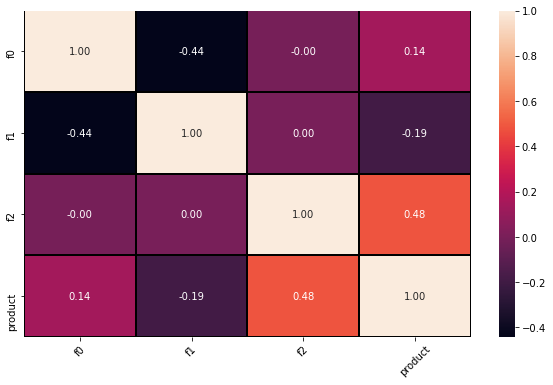

In [13]:
f,ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df1.corr(), annot=True, linewidths=.9, linecolor='black', fmt= '.2f',ax=ax)
plt.xticks(rotation= 45)
plt.show()

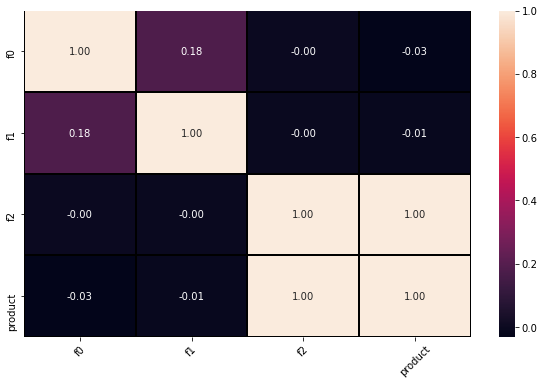

In [14]:
f,ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df2.corr(), annot=True, linewidths=.9, linecolor='black', fmt= '.2f',ax=ax)
plt.xticks(rotation= 45)
plt.show()

Здесь есть корелляция между признаком __f2__ целевым признаком __product__ . В данном случае, это значит, что целевой признак будет им хорошо предсказываться, удалять ничего не нужно

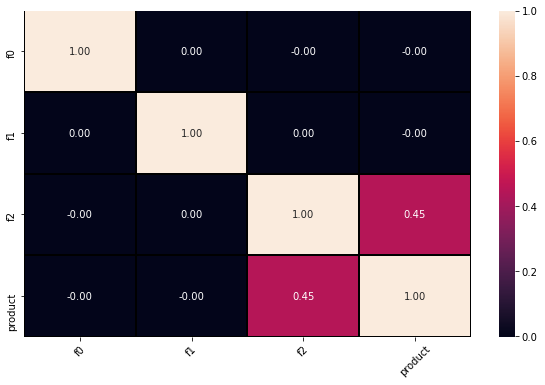

In [15]:
f,ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df3.corr(), annot=True, linewidths=.9, linecolor='black', fmt= '.2f',ax=ax)
plt.xticks(rotation= 45)
plt.show()

### Посмотрим на распределение значений

array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>,
        <AxesSubplot:title={'center':'product'}>]], dtype=object)

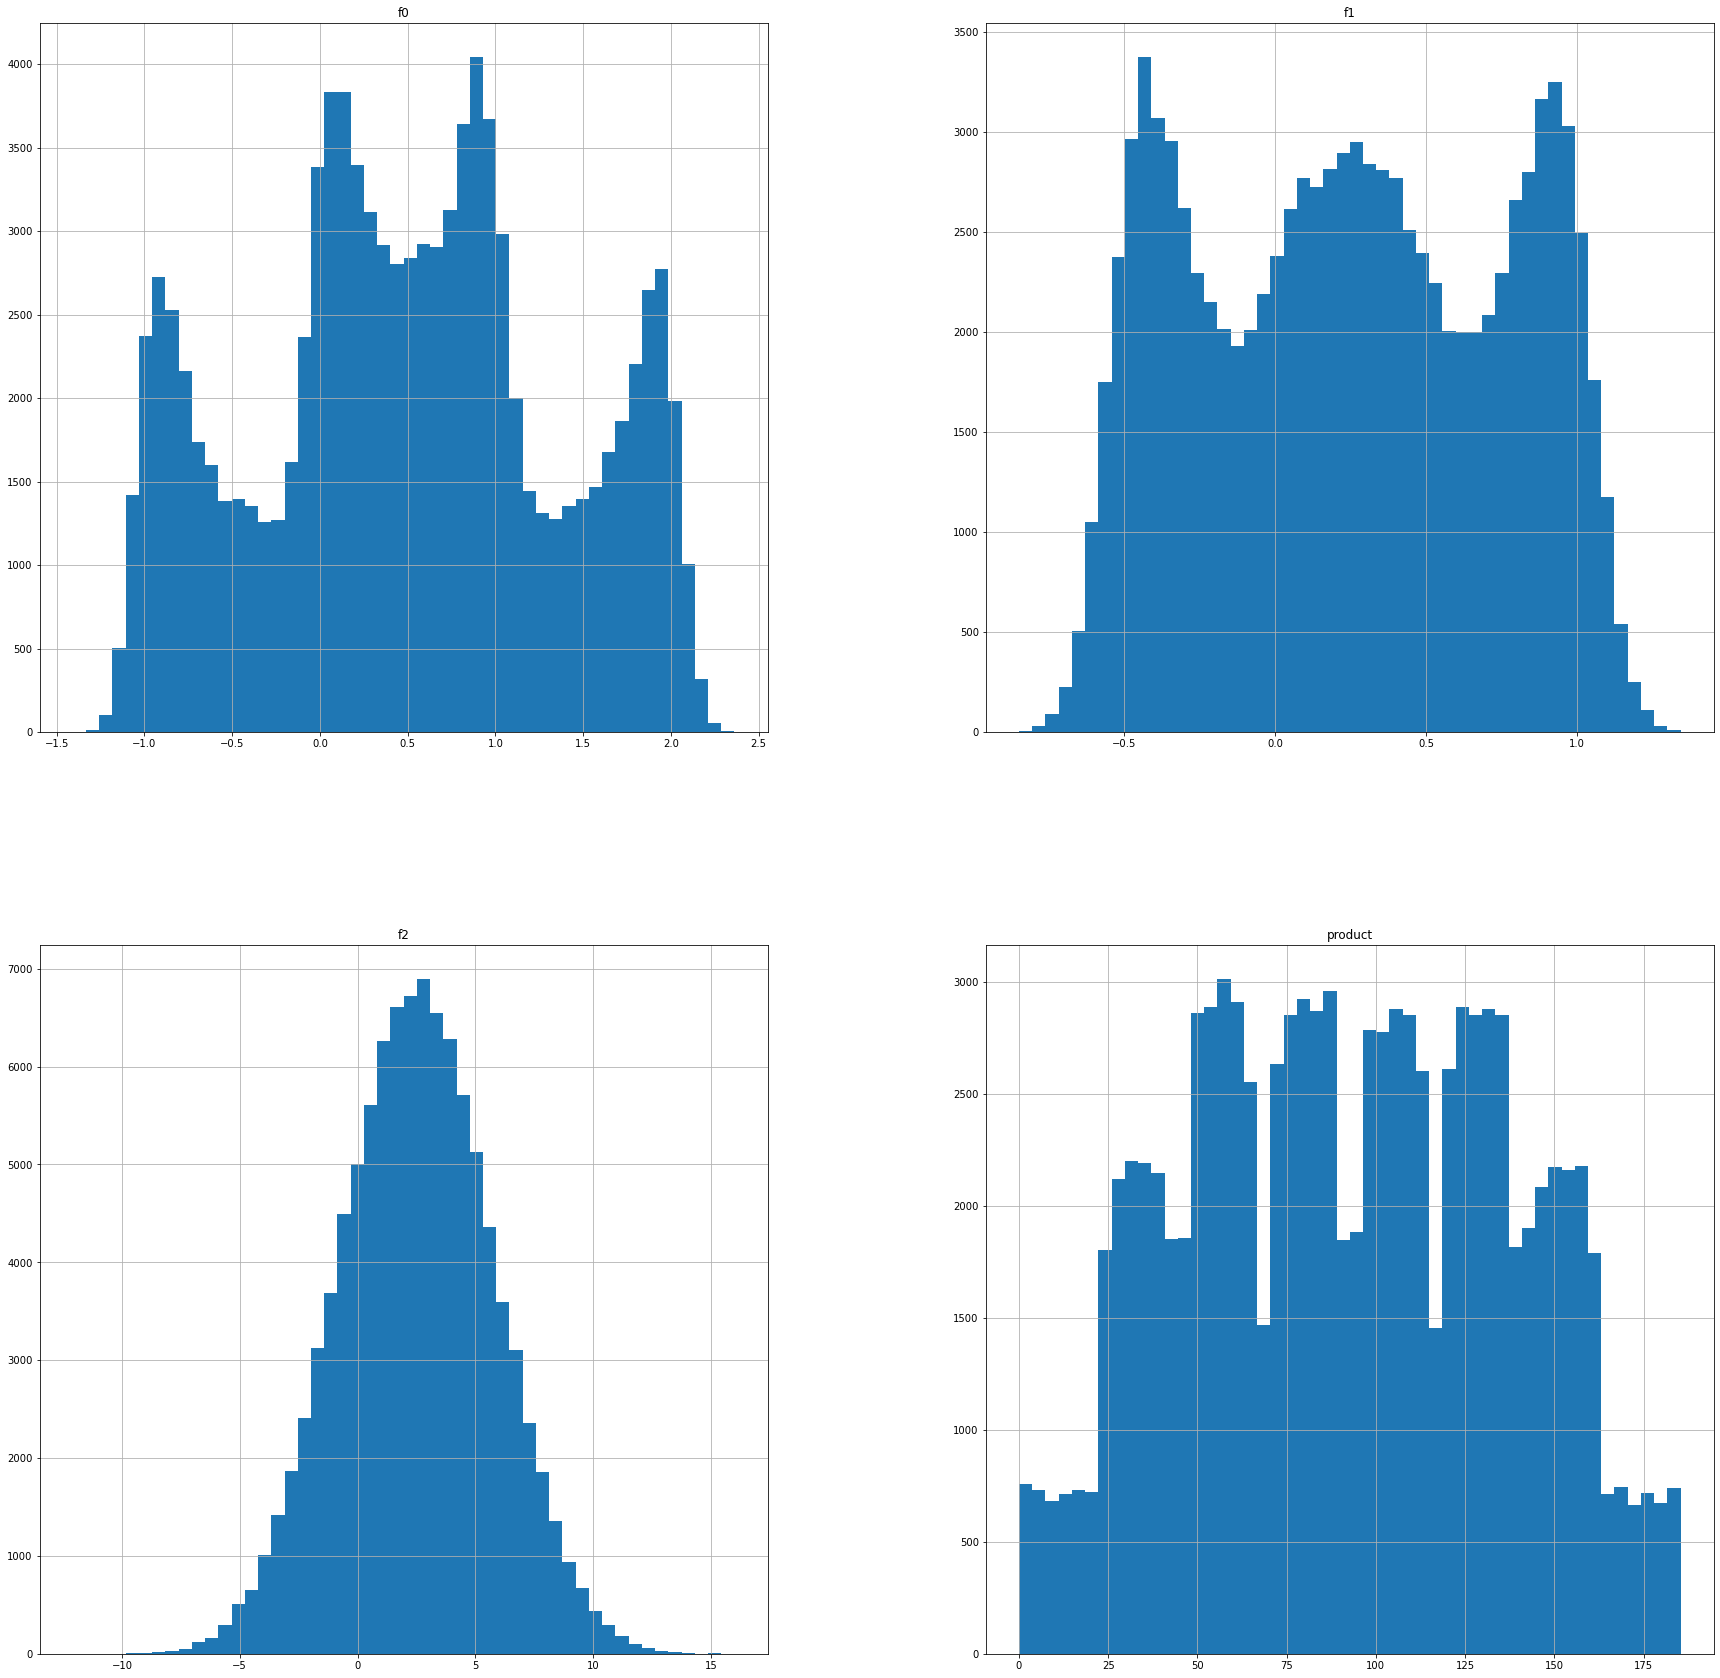

In [16]:
df1.hist(bins=50, figsize = (30,30), linewidth = 2)

array([[<AxesSubplot:xlabel='f0', ylabel='f0'>,
        <AxesSubplot:xlabel='f1', ylabel='f0'>,
        <AxesSubplot:xlabel='f2', ylabel='f0'>,
        <AxesSubplot:xlabel='product', ylabel='f0'>],
       [<AxesSubplot:xlabel='f0', ylabel='f1'>,
        <AxesSubplot:xlabel='f1', ylabel='f1'>,
        <AxesSubplot:xlabel='f2', ylabel='f1'>,
        <AxesSubplot:xlabel='product', ylabel='f1'>],
       [<AxesSubplot:xlabel='f0', ylabel='f2'>,
        <AxesSubplot:xlabel='f1', ylabel='f2'>,
        <AxesSubplot:xlabel='f2', ylabel='f2'>,
        <AxesSubplot:xlabel='product', ylabel='f2'>],
       [<AxesSubplot:xlabel='f0', ylabel='product'>,
        <AxesSubplot:xlabel='f1', ylabel='product'>,
        <AxesSubplot:xlabel='f2', ylabel='product'>,
        <AxesSubplot:xlabel='product', ylabel='product'>]], dtype=object)

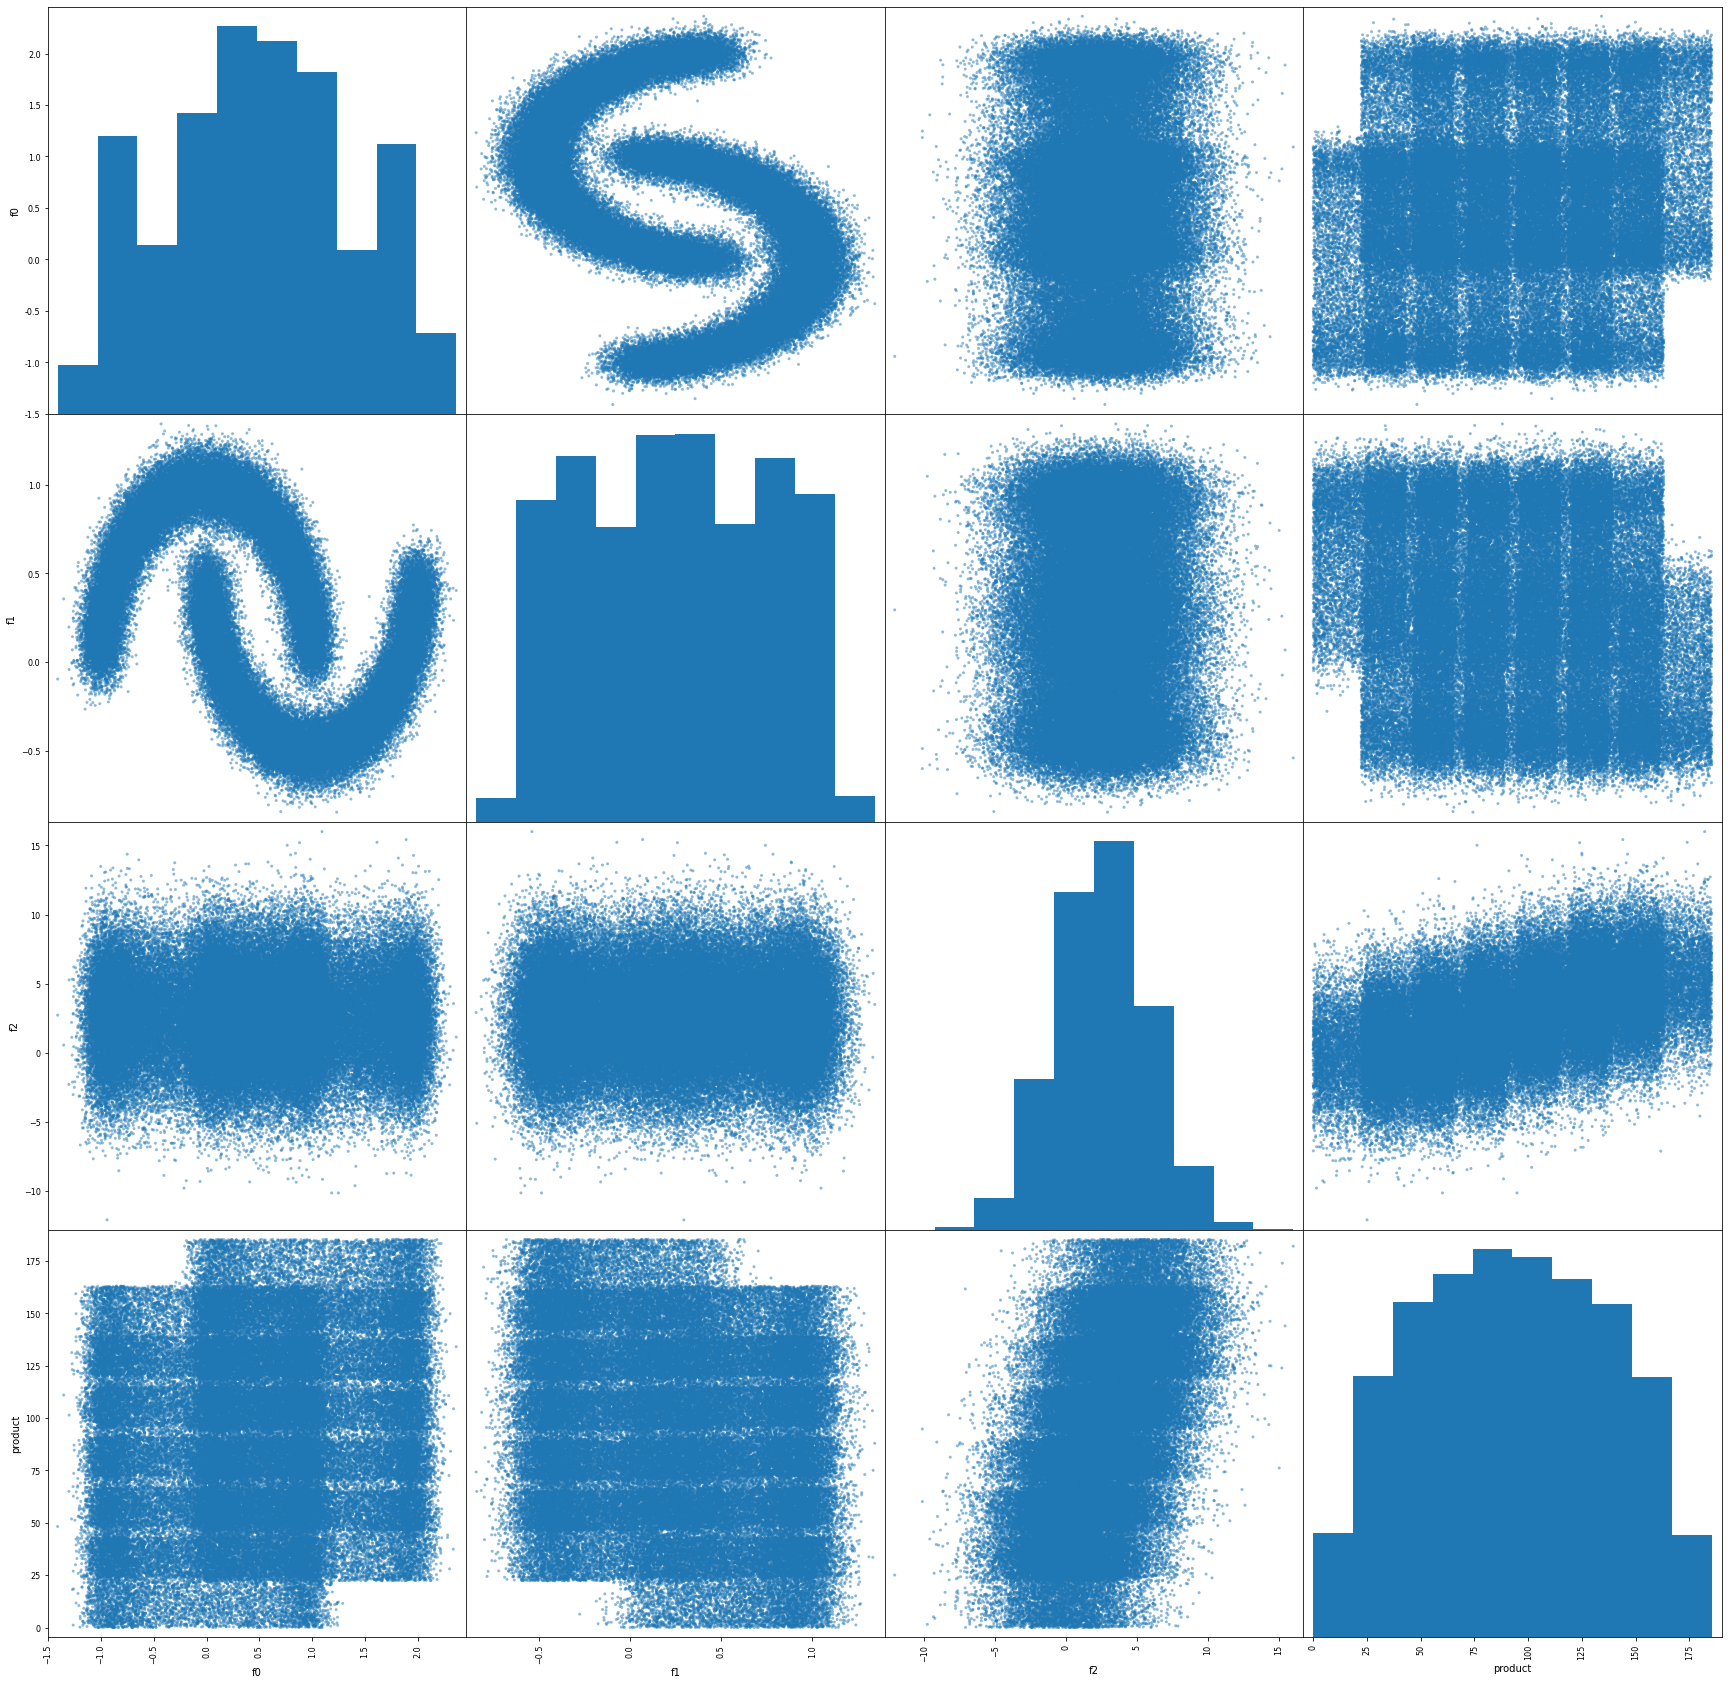

In [17]:
pd.plotting.scatter_matrix(df1, figsize = (30,30))

array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>,
        <AxesSubplot:title={'center':'product'}>]], dtype=object)

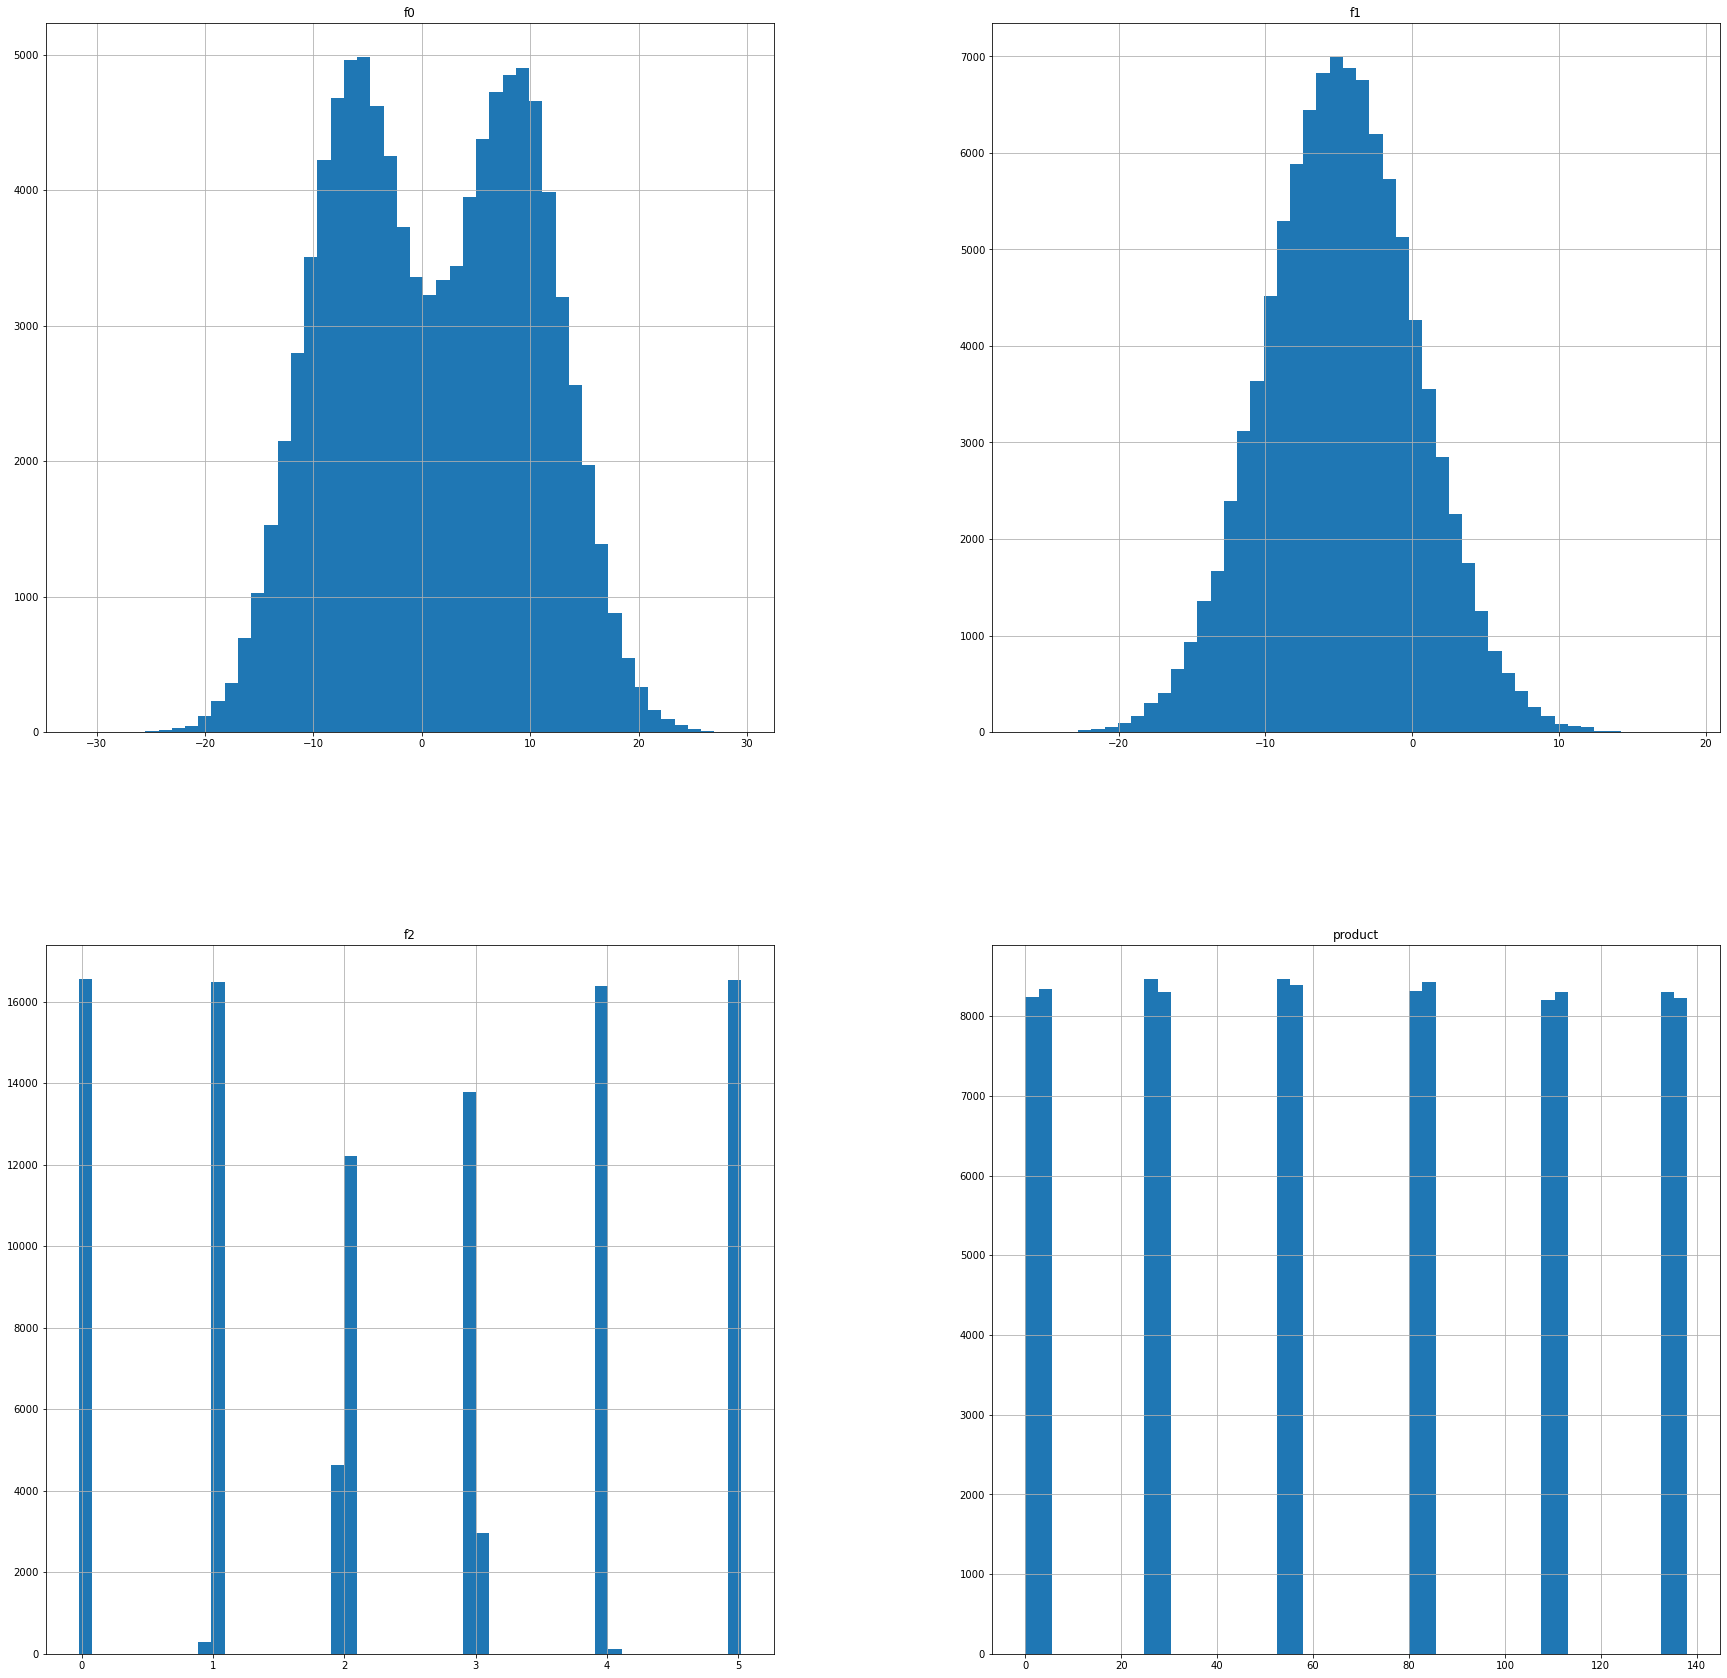

In [18]:
df2.hist(bins=50, figsize = (30,30), linewidth = 2)

array([[<AxesSubplot:xlabel='f0', ylabel='f0'>,
        <AxesSubplot:xlabel='f1', ylabel='f0'>,
        <AxesSubplot:xlabel='f2', ylabel='f0'>,
        <AxesSubplot:xlabel='product', ylabel='f0'>],
       [<AxesSubplot:xlabel='f0', ylabel='f1'>,
        <AxesSubplot:xlabel='f1', ylabel='f1'>,
        <AxesSubplot:xlabel='f2', ylabel='f1'>,
        <AxesSubplot:xlabel='product', ylabel='f1'>],
       [<AxesSubplot:xlabel='f0', ylabel='f2'>,
        <AxesSubplot:xlabel='f1', ylabel='f2'>,
        <AxesSubplot:xlabel='f2', ylabel='f2'>,
        <AxesSubplot:xlabel='product', ylabel='f2'>],
       [<AxesSubplot:xlabel='f0', ylabel='product'>,
        <AxesSubplot:xlabel='f1', ylabel='product'>,
        <AxesSubplot:xlabel='f2', ylabel='product'>,
        <AxesSubplot:xlabel='product', ylabel='product'>]], dtype=object)

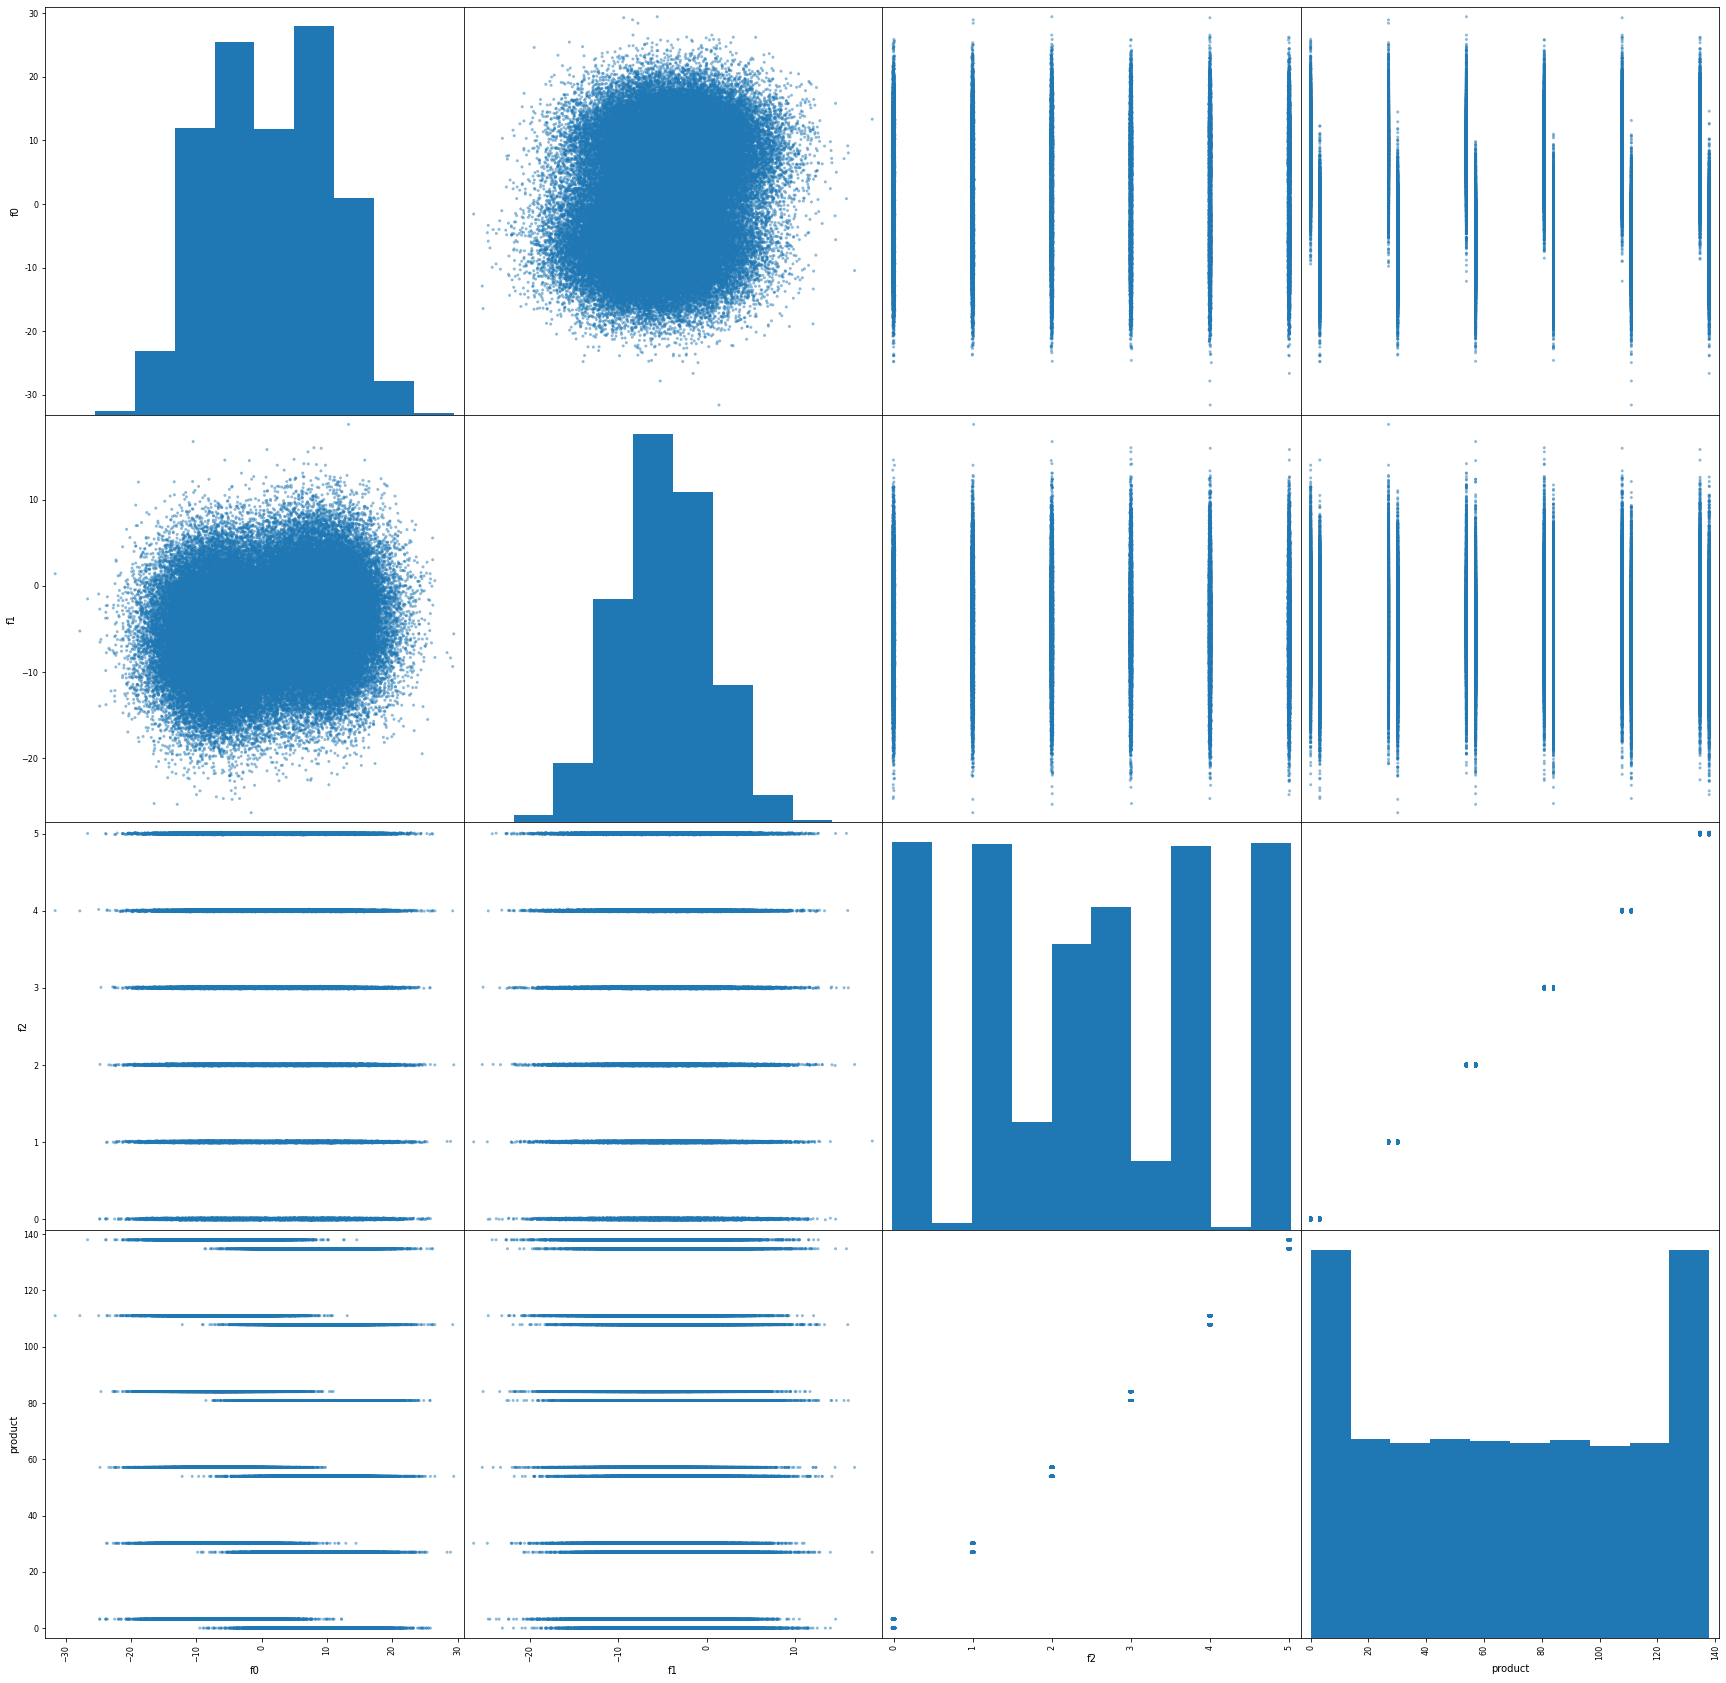

In [19]:
pd.plotting.scatter_matrix(df2, figsize = (30,30))

array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>,
        <AxesSubplot:title={'center':'product'}>]], dtype=object)

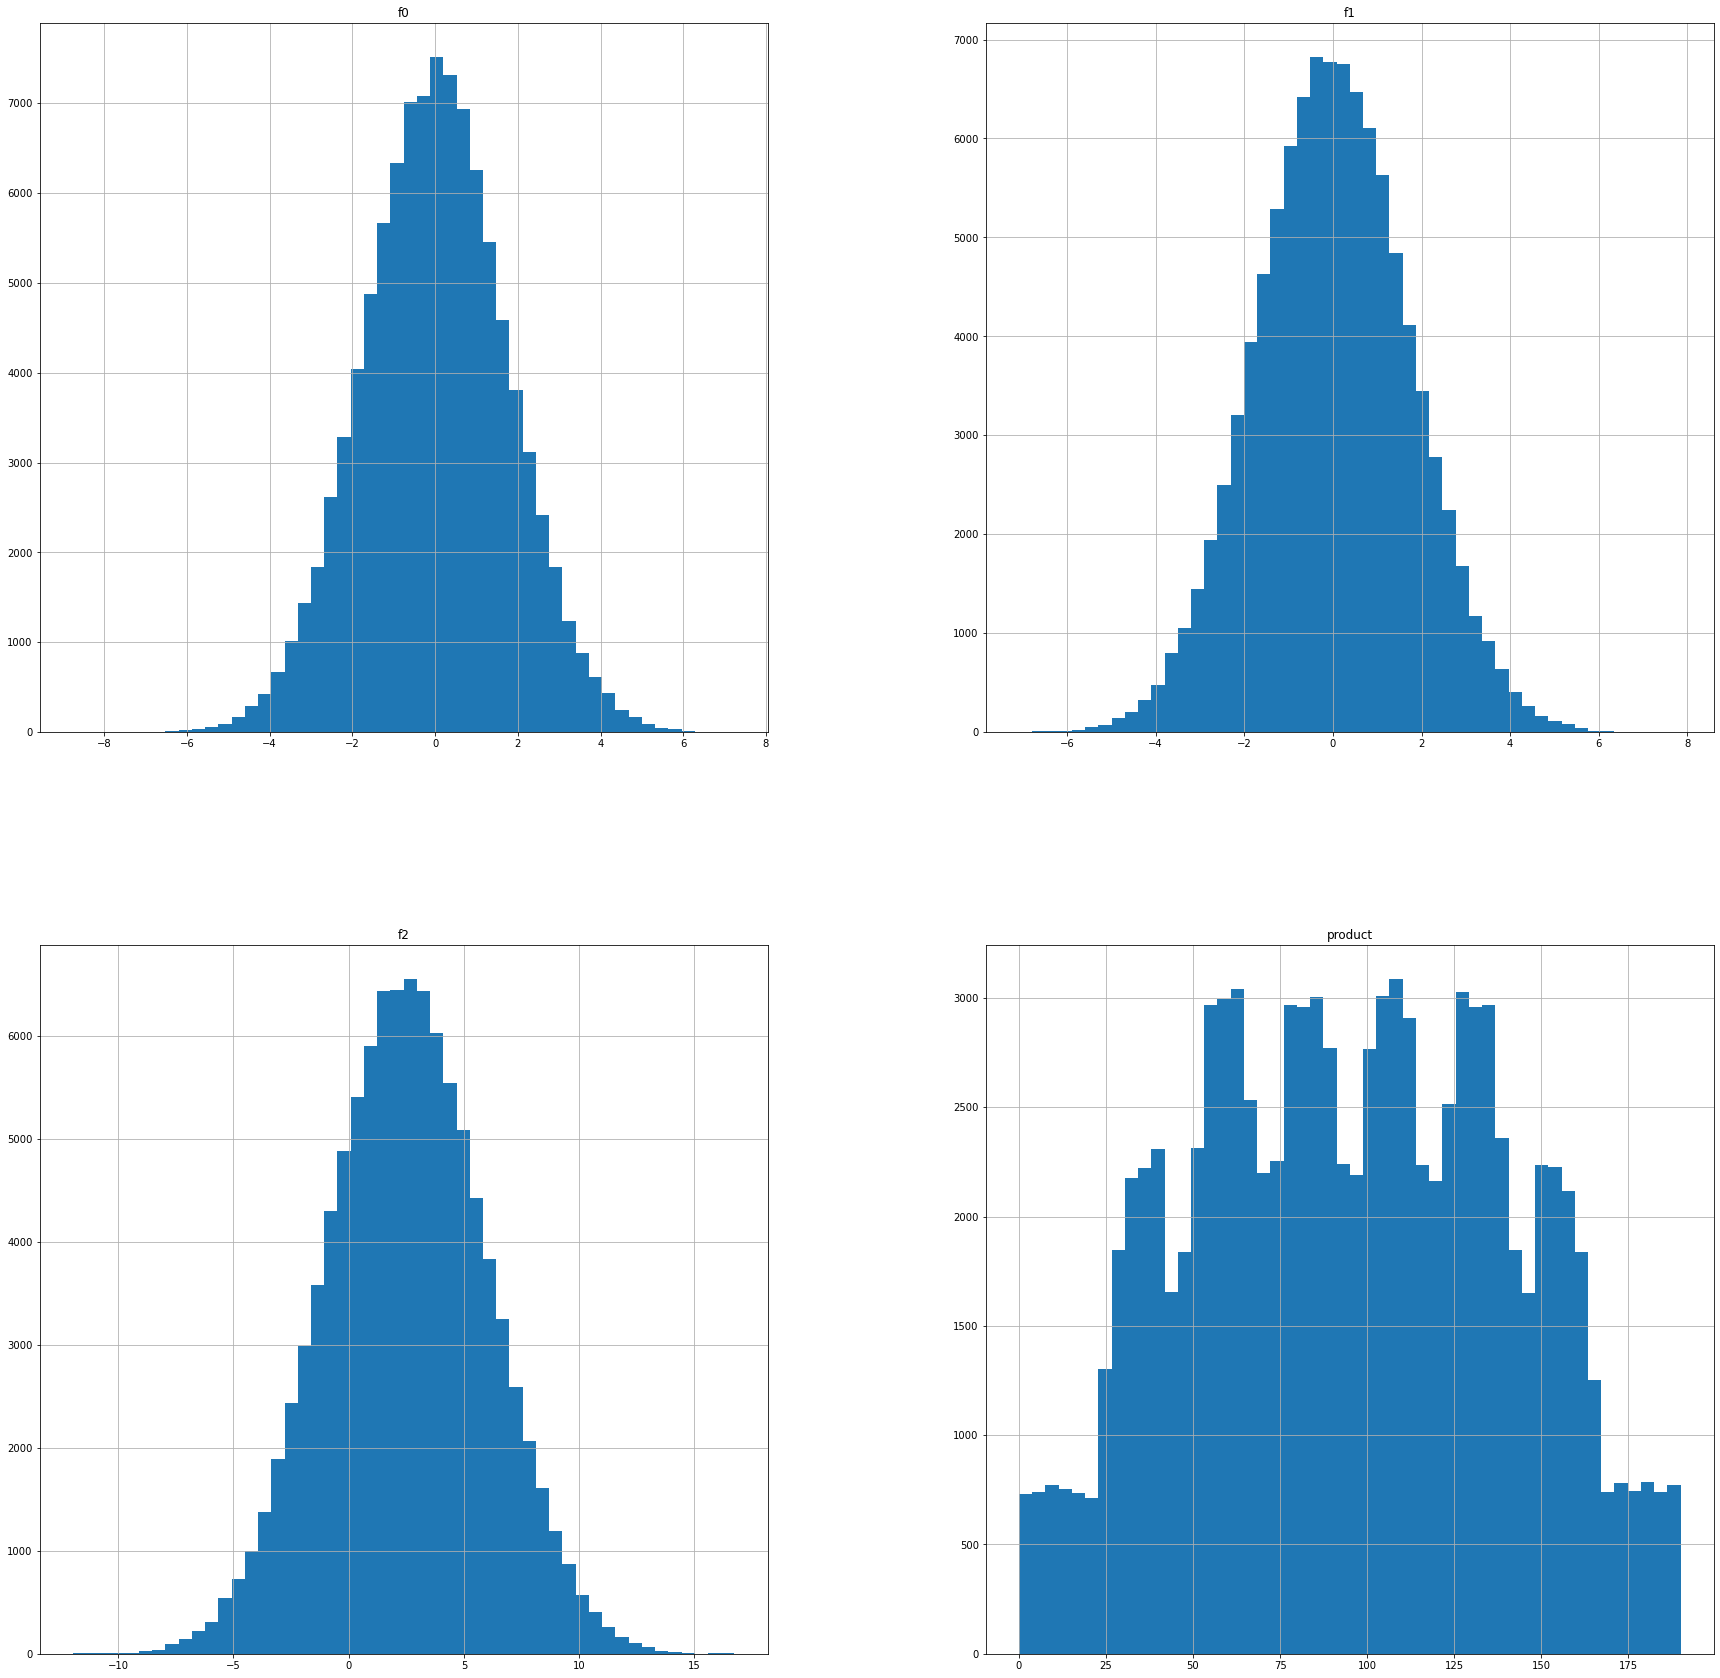

In [20]:
df3.hist(bins=50, figsize = (30,30), linewidth = 2)

array([[<AxesSubplot:xlabel='f0', ylabel='f0'>,
        <AxesSubplot:xlabel='f1', ylabel='f0'>,
        <AxesSubplot:xlabel='f2', ylabel='f0'>,
        <AxesSubplot:xlabel='product', ylabel='f0'>],
       [<AxesSubplot:xlabel='f0', ylabel='f1'>,
        <AxesSubplot:xlabel='f1', ylabel='f1'>,
        <AxesSubplot:xlabel='f2', ylabel='f1'>,
        <AxesSubplot:xlabel='product', ylabel='f1'>],
       [<AxesSubplot:xlabel='f0', ylabel='f2'>,
        <AxesSubplot:xlabel='f1', ylabel='f2'>,
        <AxesSubplot:xlabel='f2', ylabel='f2'>,
        <AxesSubplot:xlabel='product', ylabel='f2'>],
       [<AxesSubplot:xlabel='f0', ylabel='product'>,
        <AxesSubplot:xlabel='f1', ylabel='product'>,
        <AxesSubplot:xlabel='f2', ylabel='product'>,
        <AxesSubplot:xlabel='product', ylabel='product'>]], dtype=object)

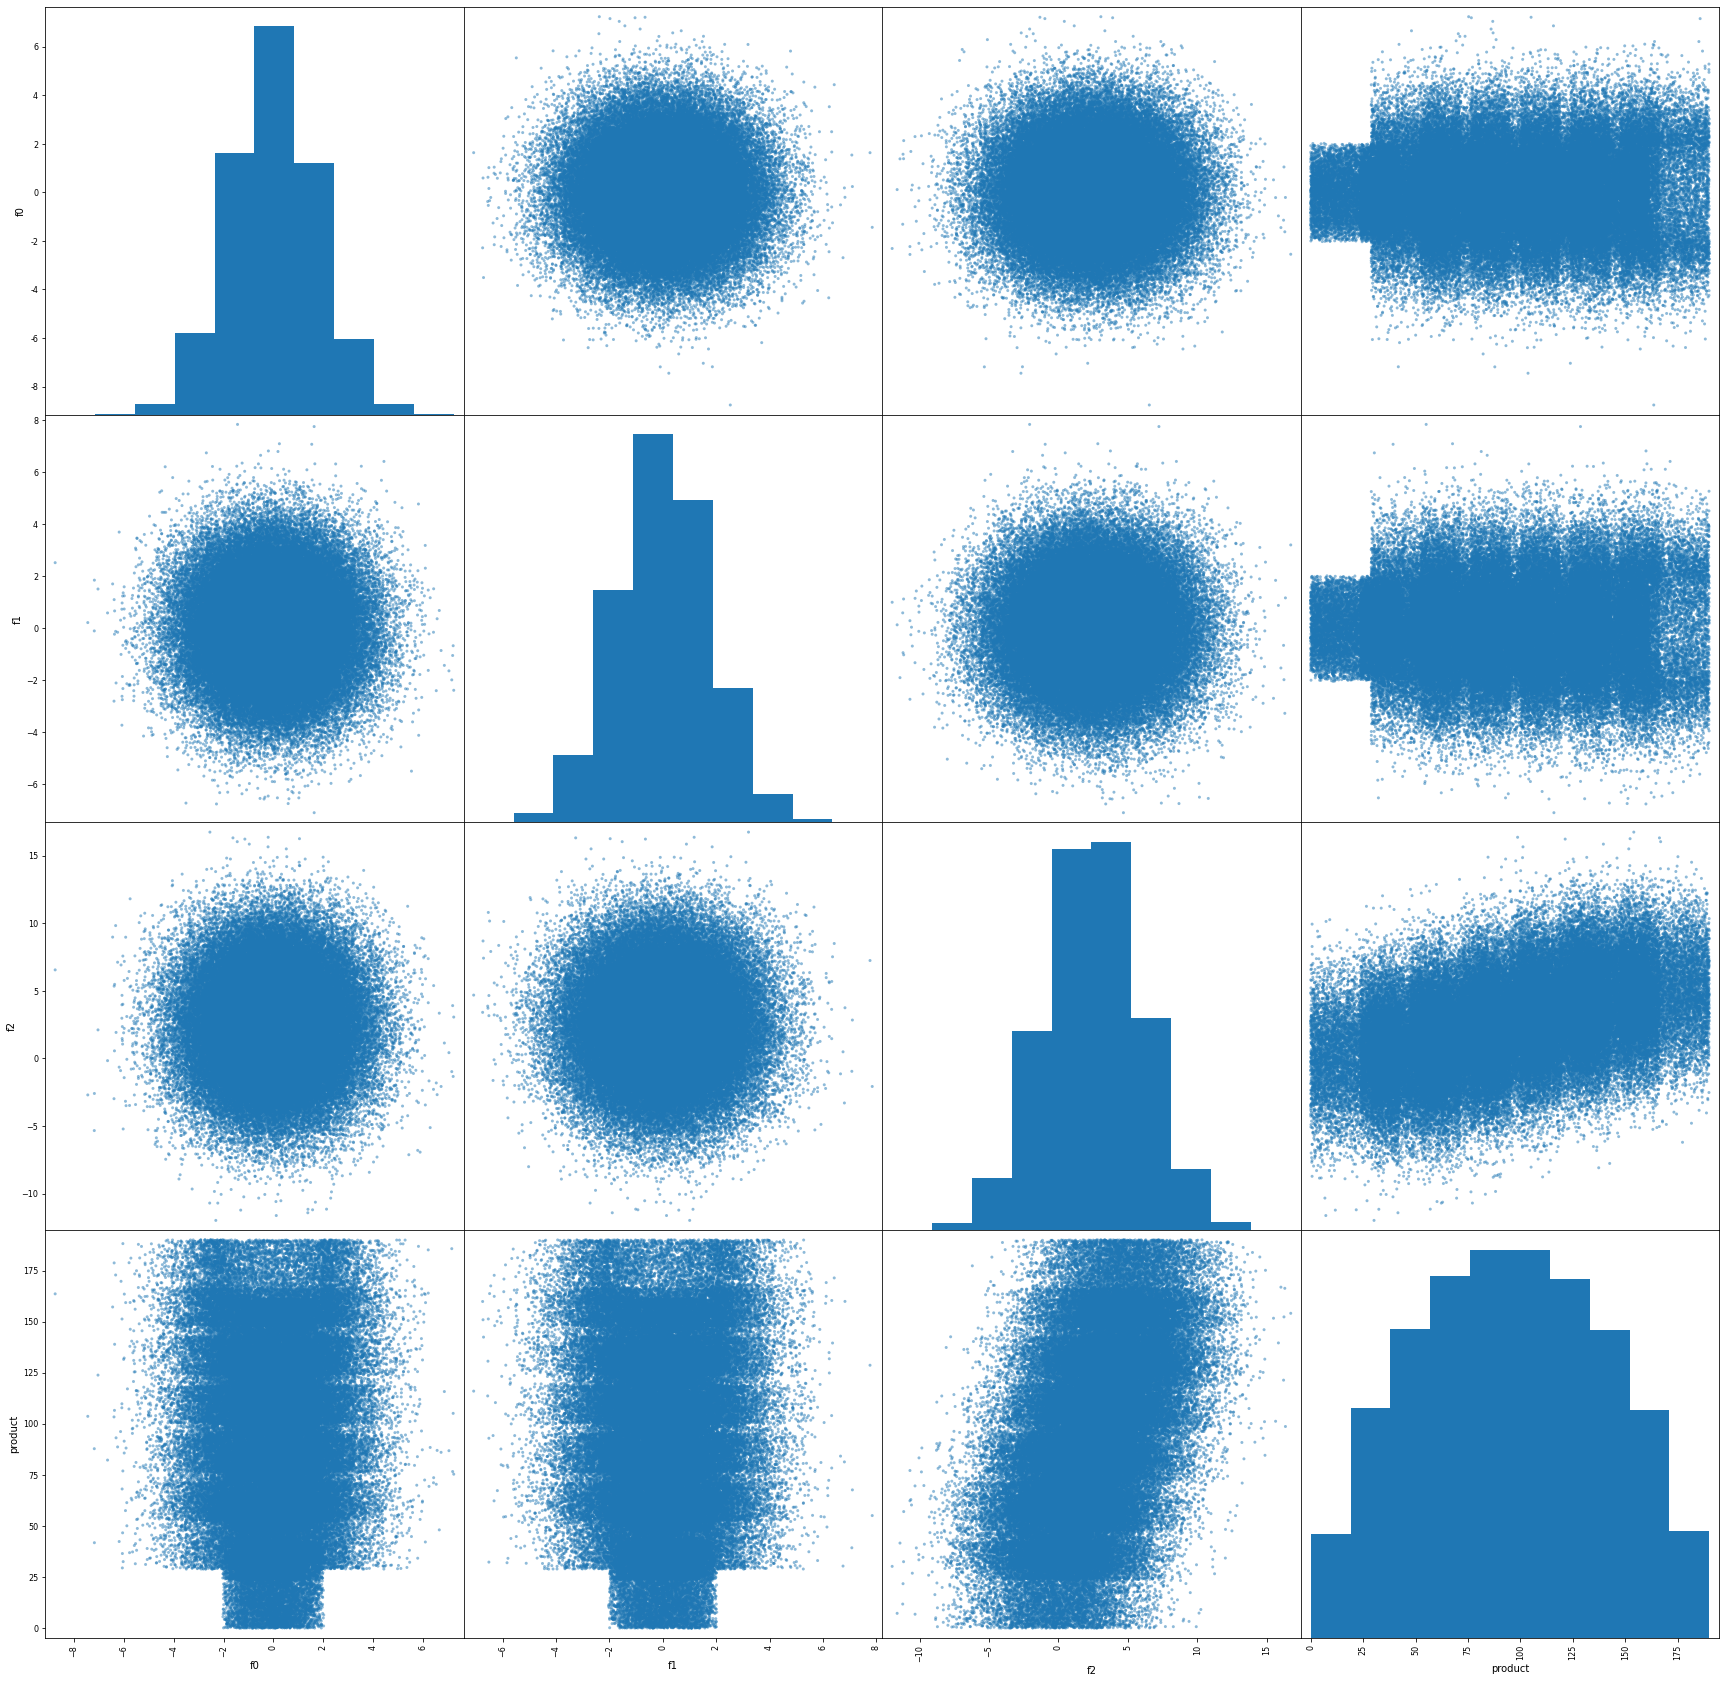

In [21]:
pd.plotting.scatter_matrix(df3, figsize = (30,30))

Судя по аккуратным симметричным распределениям (местами полимодальными) и скаттерплотам данные явно синтетические, где-то склеены выборки, либо утеряны данные. У первое и третьего регинов распределения ближе к нормальным, только во 2м регионе наблюдаются странные распределения, не

* Дубликатов в основном нет
* Пропусков нет
* Есть не самый нужный признак id, который можно будет удалить

## Обработка данных

### Уберем лишний столбец во всех 3 датасетах

In [22]:

df1 = df1.drop(['id'], axis=1)
df2 = df2.drop(['id'], axis=1)
df3 = df3.drop(['id'], axis=1)
display(df1.head(5))
display(df2.head(5))
display(df3.head(5))

f0        f1        f2     product
0  0.705745 -0.497823  1.221170  105.280062
1  1.334711 -0.340164  4.365080   73.037750
2  1.022732  0.151990  1.419926   85.265647
3 -0.032172  0.139033  2.978566  168.620776
4  1.988431  0.155413  4.751769  154.036647

f0         f1        f2     product
0 -15.001348  -8.276000 -0.005876    3.179103
1  14.272088  -3.475083  0.999183   26.953261
2   6.263187  -5.948386  5.001160  134.766305
3 -13.081196 -11.506057  4.999415  137.945408
4  12.702195  -8.147433  5.004363  134.766305

f0        f1        f2     product
0 -1.146987  0.963328 -0.828965   27.758673
1  0.262778  0.269839 -2.530187   56.069697
2  0.194587  0.289035 -5.586433   62.871910
3  2.236060 -0.553760  0.930038  114.572842
4 -0.515993  1.716266  5.899011  149.600746

## Обучение и проверка модели
Будем использовать модель линейной регрессии.

Нужно ли масштабировать модель? Протестируем модель на df1 с масштабированием и без.

### Проверка на масштабируемость

In [23]:
def split_train(df):
    """Функция разделяет датасет на выборки:
        - обучающую
        - валдиационную
        - тестовую
    Затем, обучает модель линейной регрессии,
    Возвращает:
        - среднюю квадратичную ошибку (RMSE)
        - среднее количество нефти
    """
    features = df.drop(['product'], axis=1)
    target = df['product']

    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25,
                                                                                  random_state=12345)

    lr = LinearRegression(normalize=True)
    lr.fit(features_train, target_train) # обучение модели на обучающей выборке
    predictions_valid = pd.Series(lr.predict(features_valid))

    rmse = (mean_squared_error(target_valid, predictions_valid ))**(0.5)
    average_oil = predictions_valid.mean()


    print("Среднее количество нефти: {0:.3f}".format(average_oil))
    print("RMSE: {0:.3f}".format(rmse))

    return predictions_valid, target_valid.reset_index(drop=True)

In [24]:

def split_train_scaled(df):
    """Функция разделяет датасет на выборки:
        - обучающую
        - валдиационную
        - тестовую
    Далее, масштабирует данные.
    Затем, обучает модель линейной регрессии,
    Возвращает:
        - среднюю квадратичную ошибку (RMSE)
        - среднее количество нефти
    """

    features = df.drop(['product'], axis=1)
    target = df['product']

    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25,
                                                                                  random_state=12345)

    scaler = StandardScaler()
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.transform(features_valid)

    lr = LinearRegression(normalize=True)
    lr.fit(features_train, target_train) # обучение модели на обучающей выборке
    predictions_valid = pd.Series(lr.predict(features_valid))

    rmse = (mean_squared_error(target_valid, predictions_valid ))**(0.5)
    average_oil = predictions_valid.mean()


    print("Среднее количество нефти: {0:.3f}".format(average_oil))
    print("RMSE: {0:.3f}".format(rmse))

    return predictions_valid, target_valid.reset_index(drop=True)

In [25]:
# Тестируем df1 без масштабирования:

split_train(df1)

Среднее количество нефти: 92.789
RMSE: 37.854


(0        103.950372
 1         73.687869
 2        101.015288
 3         94.048415
 4         87.559552
             ...    
 24993     63.963223
 24994    139.862730
 24995     78.444653
 24996     71.082768
 24997     66.054854
 Length: 24998, dtype: float64,
 0        123.566299
 1         63.442039
 2         88.718000
 3         51.422060
 4        102.569999
             ...    
 24993     32.531740
 24994    139.062332
 24995     55.953481
 24996     87.222042
 24997    138.866063
 Name: product, Length: 24998, dtype: float64)

In [26]:
# Тестируем df1 c масштабированием:

split_train_scaled(df1)

Среднее количество нефти: 92.789
RMSE: 37.854


(0        103.950372
 1         73.687869
 2        101.015288
 3         94.048415
 4         87.559552
             ...    
 24993     63.963223
 24994    139.862730
 24995     78.444653
 24996     71.082768
 24997     66.054854
 Length: 24998, dtype: float64,
 0        123.566299
 1         63.442039
 2         88.718000
 3         51.422060
 4        102.569999
             ...    
 24993     32.531740
 24994    139.062332
 24995     55.953481
 24996     87.222042
 24997    138.866063
 Name: product, Length: 24998, dtype: float64)

Смысла в масштабировании нет, использовать его не будем

### Обучаем модели для всех регионов

In [27]:
print('Регион 1:')
predictions_1, target_1 = split_train(df1)
print('\nРегион 2:')
predictions_2, target_2 = split_train(df2)
print('\nРегион 3:')
predictions_3, target_3 = split_train(df3)

Регион 1:
Среднее количество нефти: 92.789
RMSE: 37.854

Регион 2:
Среднее количество нефти: 68.885
RMSE: 0.890

Регион 3:
Среднее количество нефти: 95.097
RMSE: 39.944


### Вывод

На данный момент, судя по предсказаниям, самые прибыльные регионы 1 и 3. Но лучше всего предсказаны данные во 2ом регионе (RMSE = $0.890$)

## Подготовка к расчёту прибыли

Из условий:
 * у нас есть бюджет = 10млрд
 * Количество скважин, которые мы хотим выбрать
 * Доход с каждой единицы нефти (за 1 баррель)

Чтобы найти достаточный объем нефти $X$для безубыточной разработки скважины, нужно:

$$X = \frac{budget}{best_points * price}$$

In [28]:
# Бюджет
budget = 10**10

# Количество выбранных скважин
best_points = 200

# Цена за баррель
oil_price = 450*10**3

In [29]:
# Рассчитываем точку безубыточности:

print('Точка безубыточности: {0:.2f} тыс. баррелей'.format(budget/(best_points*oil_price)))

Точка безубыточности: 111.11 тыс. баррелей


### Вывод
Вспомним среднее объем нефти в регионах и сравним с точкой безубыточности:

| Регион 1       |    Регион 2     |       Регион 3       |      Точка безубыточности |
|:---------------|:---------------:|:--------------------:|--------------------------:|
| 92.789         |     68.885      |        39.944        |      111.11               |


В итоге, у нас количество нефти в среднем по всем регионам явно недостаточно для точки безубыточности

## Расчёт прибыли и рисков

### Функция расчета прибыли

Посмотрим по предиктам, какаие вышки самые прибыльные

*  Выберем скважины с максимальными значениями предсказаний.
*  Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
*  Рассчитаем прибыль для полученного объёма сырья.

In [30]:
def profit(predictions,target):
    top_predictions = predictions.sort_values(ascending=False)
    top_target = target[top_predictions.index][:best_points]

    revenue = top_target.sum() * oil_price
    return revenue - budget

In [31]:
profit(predictions_1, target_1)

3365187237.700287

In [32]:
# Функция для Bootstrap:
state = np.random.RandomState(12345)

def bootstrapping(predictions,target):
    values = []
    target = target.reset_index(drop=True)

    for j in range(1000):
        target_subsample = target.sample(500, replace=True, random_state=state)
        predictions_subsample = predictions[target_subsample.index]

        values.append(profit(predictions_subsample, target_subsample))
    return pd.Series(values)

### Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

In [33]:
def conf_interval_risk_research(predictions,target):
    results = bootstrapping(predictions,target)

    profit_mean = results.mean()

    lower = results.quantile(0.025)
    upper = results.quantile(0.975)
    risk = (results < 0).mean()

    print('Средняя прибыль: {0:.2f}'.format(profit_mean))
    print('Доверительный интервал: от', lower,'до', upper)
    print('Риск убытка: {0:.1%}'.format(risk))

In [34]:
# Считаем прибыль, доверительный интервал и риск убытков для каждого региона:
print('Регион 1:')
conf_interval_risk_research(predictions_1, target_1)
print('\nРегион 2:')
conf_interval_risk_research(predictions_2, target_2)
print('\nРегион 3:')
conf_interval_risk_research(predictions_3, target_3)


Регион 1:
Средняя прибыль: 409428038.62
Доверительный интервал: от -131536028.70166382 до 944395582.7546725
Риск убытка: 7.1%

Регион 2:
Средняя прибыль: 529145584.10
Доверительный интервал: от 122276447.11701241 до 942913055.7693316
Риск убытка: 0.7%

Регион 3:
Средняя прибыль: 393463436.45
Доверительный интервал: от -134197265.5903872 до 954815601.8272011
Риск убытка: 6.9%


### Вывод

Как видим, самые высокие риски - у 1 и 3 регионов. Очевидно, что рекомендовать можно регион 2 еще и по итогам доверительного интервала - нижняя граница сильно выше, чем у 1 и 3.

## Вывод

Итого, была проведена следующая работа:

1. Изучили данные, выявили незначительное число дубликатов
2. Обучили модель для каждого региона, без использования масштабирования, тк толку от нее не было
3. Выявили среднее число добываемой нефти в каждом регионе. Выявили так же точку безубытычности и на первый взгляд, ни один регион не соответствовал ей
4. С помощью техники бутстрепа мы пересмотрели регионы с точки зрения количества добываемой нефти, рисков и доверительного интервала и пришли к выводу, что лучший кандидат для добычы - __регион 2__.